In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from transformers import RobertaTokenizer, T5ForConditionalGeneration

import torch

from tqdm import tqdm

from helper import get_d_j_c_data_loaders, to_device, get_device, plot_data

from pathlib import Path


## Initialize globals and model

In [16]:
# GLOBALS
device = get_device()
BEAM_SIZE = 3
MAX_SEQ_LEN = 256
SOURCE_LEN = 256
LEARNING_RATE = 5e-5
EPOCHS = 20
BATCH_SIZE = 64 # change depending on the GPU Colab gives you
VAL_STEP = 20

PRETRAINED_MODEL_PATH = "../../models/doc2java/"
NEW_MODEL_PATH = "../../models/new_trained/doc2java/"
Path(NEW_MODEL_PATH).mkdir(parents=True, exist_ok=True)

torch.cuda.empty_cache()

In [17]:
token = RobertaTokenizer.from_pretrained("Salesforce/codet5-base")
train_dl , valid_dl, test_dl = get_d_j_c_data_loaders(BATCH_SIZE, token)

In [18]:
class DocToJavaModel(torch.nn.Module):
    def __init__(self, tokenizer, model_path, seq_len, beam_size):
        super(DocToJavaModel, self).__init__()
        self.tokenizer = tokenizer
        self.beam_size = beam_size
        self.seq_len = seq_len
        self.doc_to_java = T5ForConditionalGeneration.from_pretrained(model_path)

    def forward(self, input_ids, attention_mask, labels):
        doc_out = self.doc_to_java(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return doc_out.loss

    def generate_code(self, input_ids):
        gen = self.doc_to_java.generate(input_ids, max_length=self.seq_len, num_beams=self.beam_size)
        return [self.tokenizer.decode(entry, skip_special_tokens=True) for entry in gen]
    
    def save(self, path):
        torch.save(self.state_dict(), path + "DocToJavaModel.pkl")
        self.doc_to_java.save_pretrained(path)

## Train and validate model

In [19]:
@torch.no_grad()
def validate(model, val_load):
    outputs = [model(batch['doc_ids'], batch['doc_mask'], batch['j_ids']).detach().cpu() for batch in val_load]
    return np.average(outputs)

In [20]:
def train(clf, opt, dl, val, val_step):
    local_loss = []
    val_loss = []
    for _ in tqdm(range(EPOCHS)):
        for i, data in enumerate(dl):
            mod_out = clf(data['doc_ids'], data['doc_mask'], data['j_ids'])
            local_loss.append(mod_out.detach().cpu())
            
            clf.zero_grad()
            mod_out.backward()
            opt.step()

            if i % val_step == 0 and i != 0:
                val_loss.append(validate(clf, val))
        
        print(f"Average Training loss = {np.average(local_loss)}")
        print(f"Average Validation loss = {np.average(val_loss)}")
        
    return local_loss, val_loss

In [21]:
model = to_device(DocToJavaModel(token, PRETRAINED_MODEL_PATH, MAX_SEQ_LEN, BEAM_SIZE), device)
rob_optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [22]:
t_loss, v_loss = train(model, rob_optimizer, train_dl, valid_dl, VAL_STEP)

  5%|▌         | 1/20 [01:32<29:23, 92.83s/it]

Average Training loss = 0.5014855861663818
Average Validation loss = 0.41296789050102234


 10%|█         | 2/20 [02:55<26:04, 86.93s/it]

Average Training loss = 0.39412927627563477
Average Validation loss = 0.35715991258621216


 15%|█▌        | 3/20 [04:18<24:07, 85.15s/it]

Average Training loss = 0.3381462097167969
Average Validation loss = 0.3267807066440582


 20%|██        | 4/20 [05:41<22:28, 84.30s/it]

Average Training loss = 0.2981089949607849
Average Validation loss = 0.3071773946285248


 25%|██▌       | 5/20 [07:04<20:57, 83.86s/it]

Average Training loss = 0.26557719707489014
Average Validation loss = 0.2938079237937927


 30%|███       | 6/20 [08:27<19:29, 83.54s/it]

Average Training loss = 0.23771367967128754
Average Validation loss = 0.28456178307533264


 35%|███▌      | 7/20 [09:50<18:04, 83.42s/it]

Average Training loss = 0.21344870328903198
Average Validation loss = 0.2782759368419647


 40%|████      | 8/20 [11:13<16:40, 83.34s/it]

Average Training loss = 0.1924610286951065
Average Validation loss = 0.27424317598342896


 45%|████▌     | 9/20 [12:37<15:16, 83.29s/it]

Average Training loss = 0.1744554042816162
Average Validation loss = 0.27181175351142883


 50%|█████     | 10/20 [14:00<13:52, 83.23s/it]

Average Training loss = 0.15923847258090973
Average Validation loss = 0.27041903138160706


 55%|█████▌    | 11/20 [15:23<12:28, 83.15s/it]

Average Training loss = 0.14639051258563995
Average Validation loss = 0.2694757282733917


 60%|██████    | 12/20 [16:46<11:04, 83.10s/it]

Average Training loss = 0.1353355050086975
Average Validation loss = 0.2689671516418457


 65%|██████▌   | 13/20 [18:09<09:41, 83.09s/it]

Average Training loss = 0.12569698691368103
Average Validation loss = 0.2686084508895874


 70%|███████   | 14/20 [19:32<08:18, 83.13s/it]

Average Training loss = 0.11725948750972748
Average Validation loss = 0.26851147413253784


 75%|███████▌  | 15/20 [20:55<06:55, 83.12s/it]

Average Training loss = 0.10985849052667618
Average Validation loss = 0.26865145564079285


 80%|████████  | 16/20 [22:18<05:32, 83.12s/it]

Average Training loss = 0.10332699865102768
Average Validation loss = 0.2689470052719116


 85%|████████▌ | 17/20 [23:41<04:09, 83.09s/it]

Average Training loss = 0.0975302904844284
Average Validation loss = 0.26934173703193665


 90%|█████████ | 18/20 [25:04<02:46, 83.09s/it]

Average Training loss = 0.09235591441392899
Average Validation loss = 0.269808828830719


 95%|█████████▌| 19/20 [26:27<01:22, 82.99s/it]

Average Training loss = 0.08770931512117386
Average Validation loss = 0.27041465044021606


100%|██████████| 20/20 [27:50<00:00, 83.51s/it]

Average Training loss = 0.08351550251245499
Average Validation loss = 0.2710678279399872


## Save Model

In [9]:
model.save(NEW_MODEL_PATH)

Ls:  3220
Ls:  160


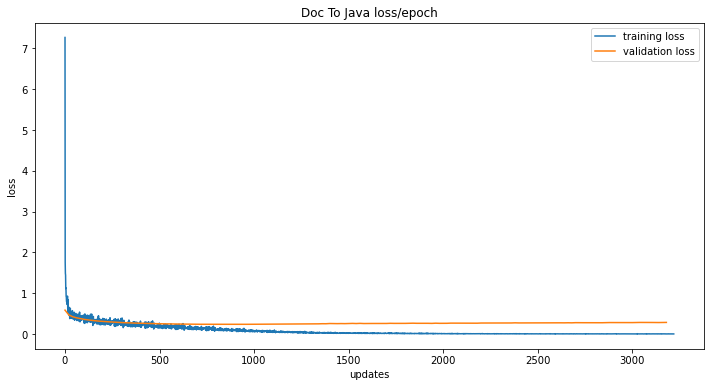

In [23]:
plot_data((t_loss, v_loss ), ('training loss', 'validation loss'), (len(t_loss), len(v_loss) )  , (1, VAL_STEP) , 'updates' , 'loss' , 'Doc To Java loss/epoch')

In [11]:
@torch.no_grad()
def sample(clf, dl):
    sent_data = []
    for data in tqdm(dl):
        with torch.no_grad():
            sent_data += clf.generate_code(data['doc_ids'])
        
    return sent_data

In [12]:
doc_data = [sample(model, dl) for dl in (train_dl, valid_dl, test_dl)]

100%|██████████| 16/16 [03:15<00:00, 12.22s/it]


In [13]:
dataset_path = "../../datasets/"

for name, d_data in zip(('train.new.java', 'valid.new.java' , 'test.new.java'), tuple(doc_data)):
    with open(dataset_path + name, 'w') as f:
        for item in d_data:
            f.write("%s\n" % item)